# AP1: Hands-on tutorial 1: Tier 1 Dataset and a simple dense neural network



In this jupyter notebook we will get some hands-on experience with the material covered in the presentation on the maelstrom application A1. The presentation can be found here: https://docs.google.com/presentation/d/1hZebZv4x0MjsYyc68PU6NXWKq_meq23IYhNAxOmu72I/edit#slide=id.g139df7f9683_19_7

## Set up on environment
This section describes how to set up the required pacakges. This is not needed if you are running in JupyterLab on JSC.

In [1]:
# !pip install climetlab climetlab_maelstrom_yr matplotlib tensorflow


## Part 1: The dataset

In this part, we will get a feel for what the dataset in AP1 looks like. The full dataset contains temperature weather forecasts for the Nordic region, and are used to produce public weather forecasts on the weather app Yr (www.yr.no). The goal of the prediction task is to generate a deterministic temperature forecast together with an uncertainty range (10% to 90%) as shown here: https://www.yr.no/en/details/graph/5-18700/Norway/Oslo/Oslo/Oslo%20(Blindern).

The target field in the dataset is constructed using a high density network of citizen weather stations from Netatmo.

In this notebook we will use a subset of the full dataset (Tier 1), which has a grid size of 128 x 128 (1 km resolution) and consists of 10 leadtimes (hour: 0, 6, 12, ..., 54). The grid is centered around the Oslo regino. The dataset is stored in 675 netCDF files and covers a two year period 2020/03/01 to 2022/02/28, with a few missing dates.

Usually, reading datasets can be a complex process, requiring many pre-processing steps as multiple sources are merged. We have done this process for you, and data can be retrieved the `climetlab` package (more information here: https://climetlab.readthedocs.io/). Let's first try to load a single file. In particular, we will load the forecast issued at 2022/01/31 at 15:00 UTC and the corresponding observations (targets) of that forecast period. Once the loader is initialized, we can retrieve the data using the `loader.to_xarray()` function, which provides the data as an xarray object.

#### Load the data

In [5]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment this to train on CPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

import climetlab as cml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

%matplotlib inline

/p/project/training2330/kreshpa1/jupyter/kernels/venv_bootcamp3/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [6]:
loader = cml.load_dataset("maelstrom-yr", dates=pd.date_range(start="2022-01-01", end="2022-01-31", freq="1D"), size="5GB", location="/p/project/training2330/AP1/")
dataset = loader.to_xarray()
print(dataset)

Cannot load module climetlab_maelstrom_downscaling.downscaling
Traceback (most recent call last):
  File "/p/project/training2330/kreshpa1/jupyter/kernels/venv_bootcamp3/lib/python3.10/site-packages/climetlab/core/plugins.py", line 187, in directories
    module = import_module(v.module_name)
  File "/p/software/jurecadc/stages/2023/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/p/project/training2330/kreshpa1/jupyter/kernels/venv_b

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/metno/maelstrom_yr/LICENSE. If you do not agree with such terms, do not download the data. 
<xarray.Dataset>
Dimensions:     (time: 30, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2022-01-01T03:00:00 ... 2022-01-31T15:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 -3.172 .

Printing out the dataset reveals its structure (dimensions and variables). As you can see, the input data is stored in the "predictors" variable, and has 4 dimensions (time, leadtime, y, x, predictor). Targets are stored in the "targets" variable. Note the order of the dimensions, as this will be important throughout the notebook.

The variables "predictor" contains the names of each of the 14 predictors, "time" contains the timestamp of the forecast initialization for this particular file, and "leadtime" contains the forecast leadtime in seconds.

#### Visualize the data

Let's visualize some of the predictors in the dataset by plotting them on a map using matplotlib:

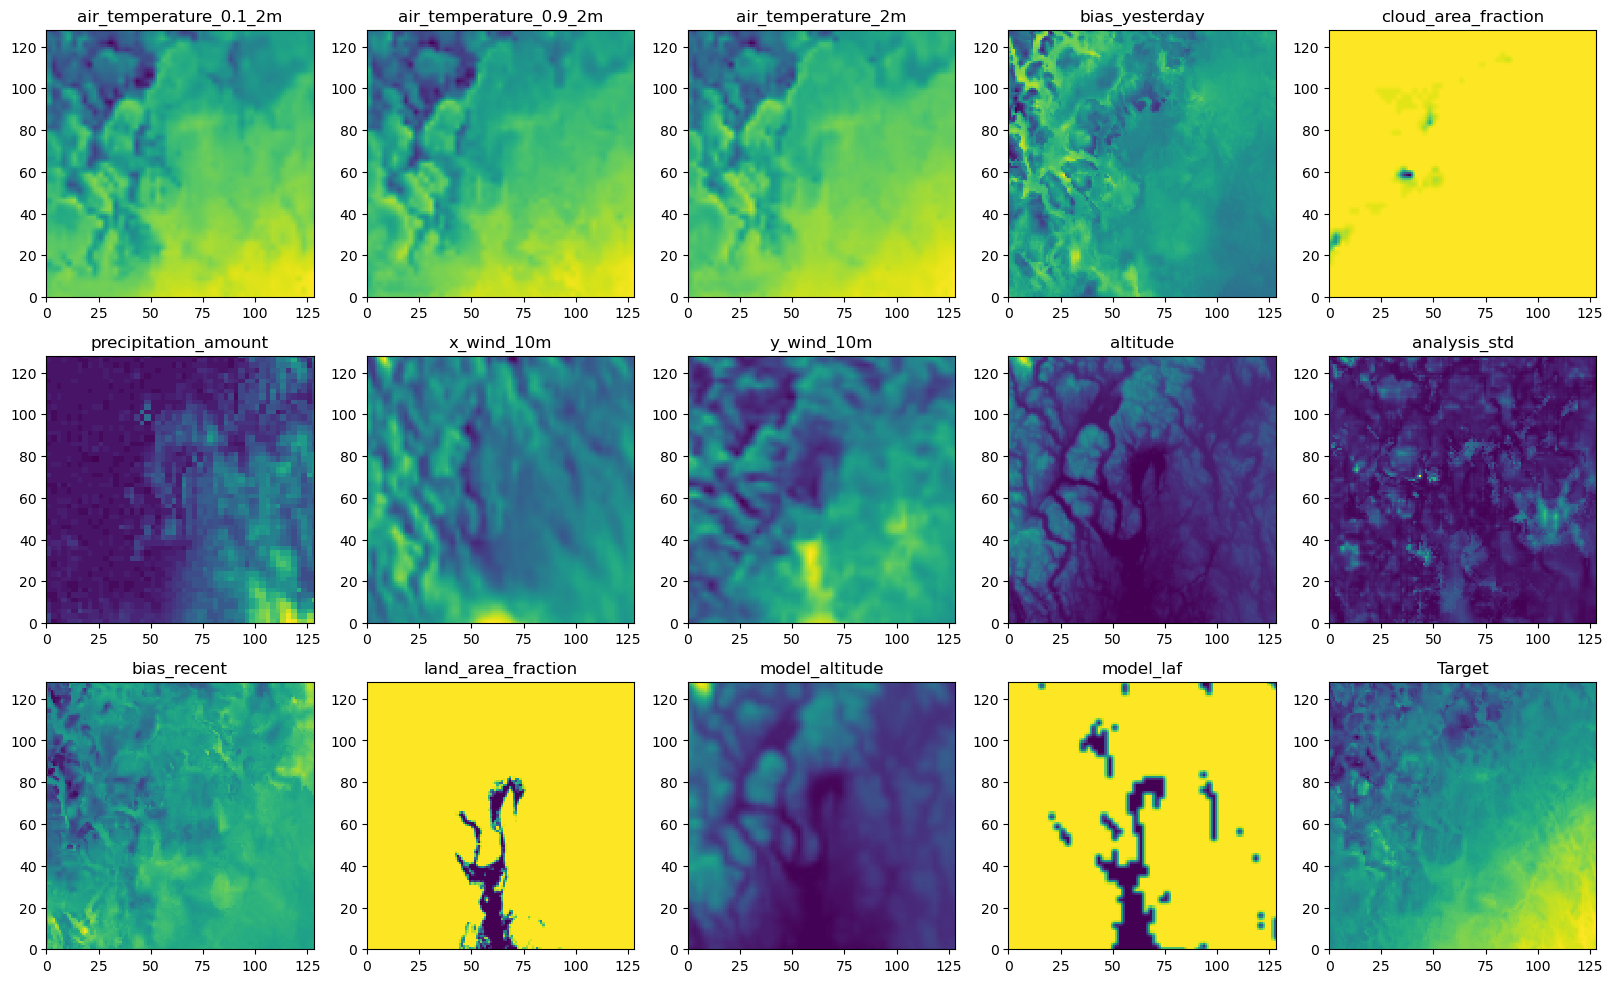

In [4]:
def plot_predictors_and_target(predictor_names, predictors, target, leadtime,  time=0):

    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = [20, 12]
    for i, name in enumerate(predictor_names):
        plt.subplot(3, 5, i + 1)
        index = np.where(predictor_names == name)[0][0]
        plt.pcolormesh(predictors[time, leadtime, :,:, index], shading="auto", rasterized=True)
        plt.gca().set_aspect(1)
        plt.title(name)
    plt.subplot(3, 5, 15)
    plt.pcolormesh(target[time, leadtime, :, :,0], shading="auto", rasterized=True)
    plt.gca().set_aspect(1)
    plt.title("Target")
    plt.show()

leadtime = 6
time =  0
plot_predictors_and_target(dataset["predictor"].values, dataset["predictors"].values, dataset["targets"].values, leadtime, time)


#### Plotting time series

Let's now look at the input and the target for a specific gridpoint. We will first define a function for this, which can then be reused later on if needed. We will plot three of the 14 predictors. These include the ensemble control temperature forecast (air_temperature_2m) and two quantiles from the ensemble (air_temperature_0.1_2m and air_temperature_0.9_2m). These predictors can be considered to be the raw forecasts, and is what we would use if we do not use machine learning to improve the forecast.

In [5]:
def plot_timeseries(middle, target, lower, upper, leadtimes, middle_label, lower_label="10th percentile", upper_label="90th percentile", target_label="Target"):
    times = leadtimes / 3600
    fig, ax = plt.subplots()
    ax.plot(times, lower, color="tab:blue", label=lower_label)
    ax.plot(times, upper, color="tab:blue", label=upper_label)
    ax.fill_between(times, lower, upper, alpha=0.2)
    ax.plot(times, target , '--o', color="tab:red", label=target_label)
    ax.plot(times, middle, color="tab:green", label=middle_label)
    ax.set_xlabel("Lead time (hours)")
    ax.set_xticks(times)
    ax.set_ylabel("Air temperature (°C)")
    plt.legend()
    plt.show()

[     0.  21600.  43200.  64800.  86400. 107999. 129600. 151199. 172800.
 194400.]


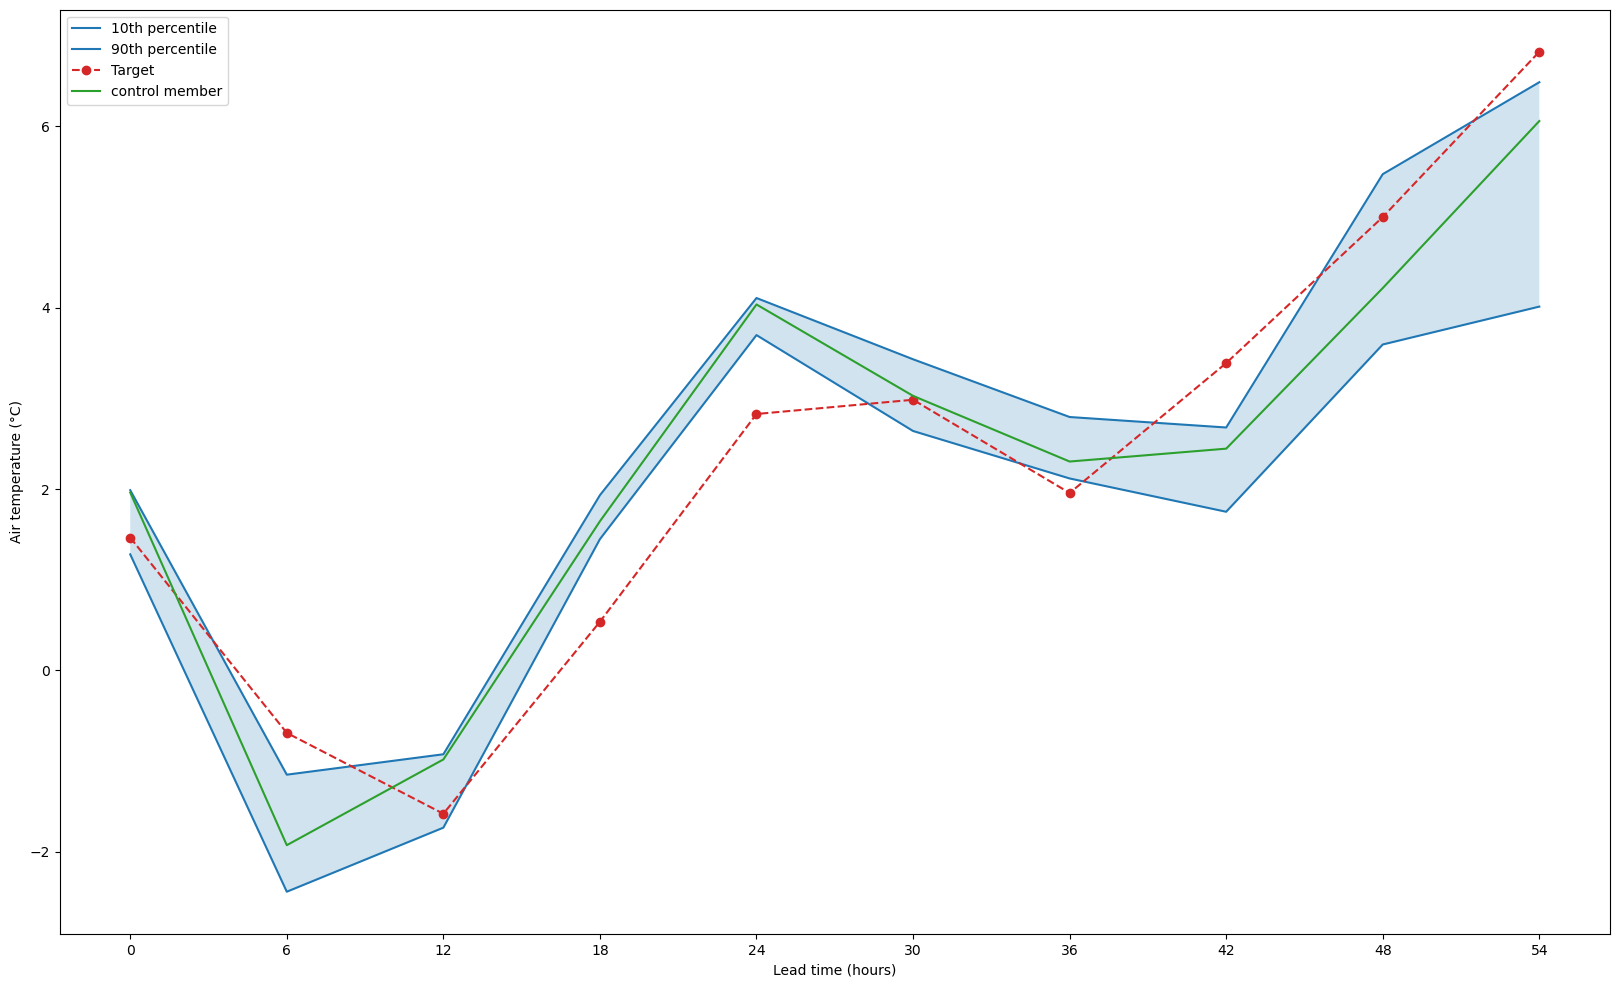

In [6]:
# Pick a specific gridpoint (must be between 0 and 127 for this particular dataset)
ix = 10
iy = 10
it = 10
lower = dataset["predictors"].values[it,:,ix,iy,np.where(dataset["predictor"] == "air_temperature_0.1_2m")[0][0]]
upper = dataset["predictors"].values[it,:,ix,iy,np.where(dataset["predictor"] == "air_temperature_0.9_2m")[0][0]]
middle = dataset["predictors"].values[it,:,ix,iy,np.where(dataset["predictor"] == "air_temperature_2m")[0][0]]
middle_label = "control member"
target = dataset["targets"].values[it,:,ix,iy]
leadtimes = dataset["leadtime"].values.astype(np.float32) // 1e9
print(leadtimes)
plot_timeseries(middle, target, lower, upper, leadtimes, middle_label)

[     0.  21600.  43200.  64800.  86400. 107999. 129600. 151199. 172800.
 194400.]


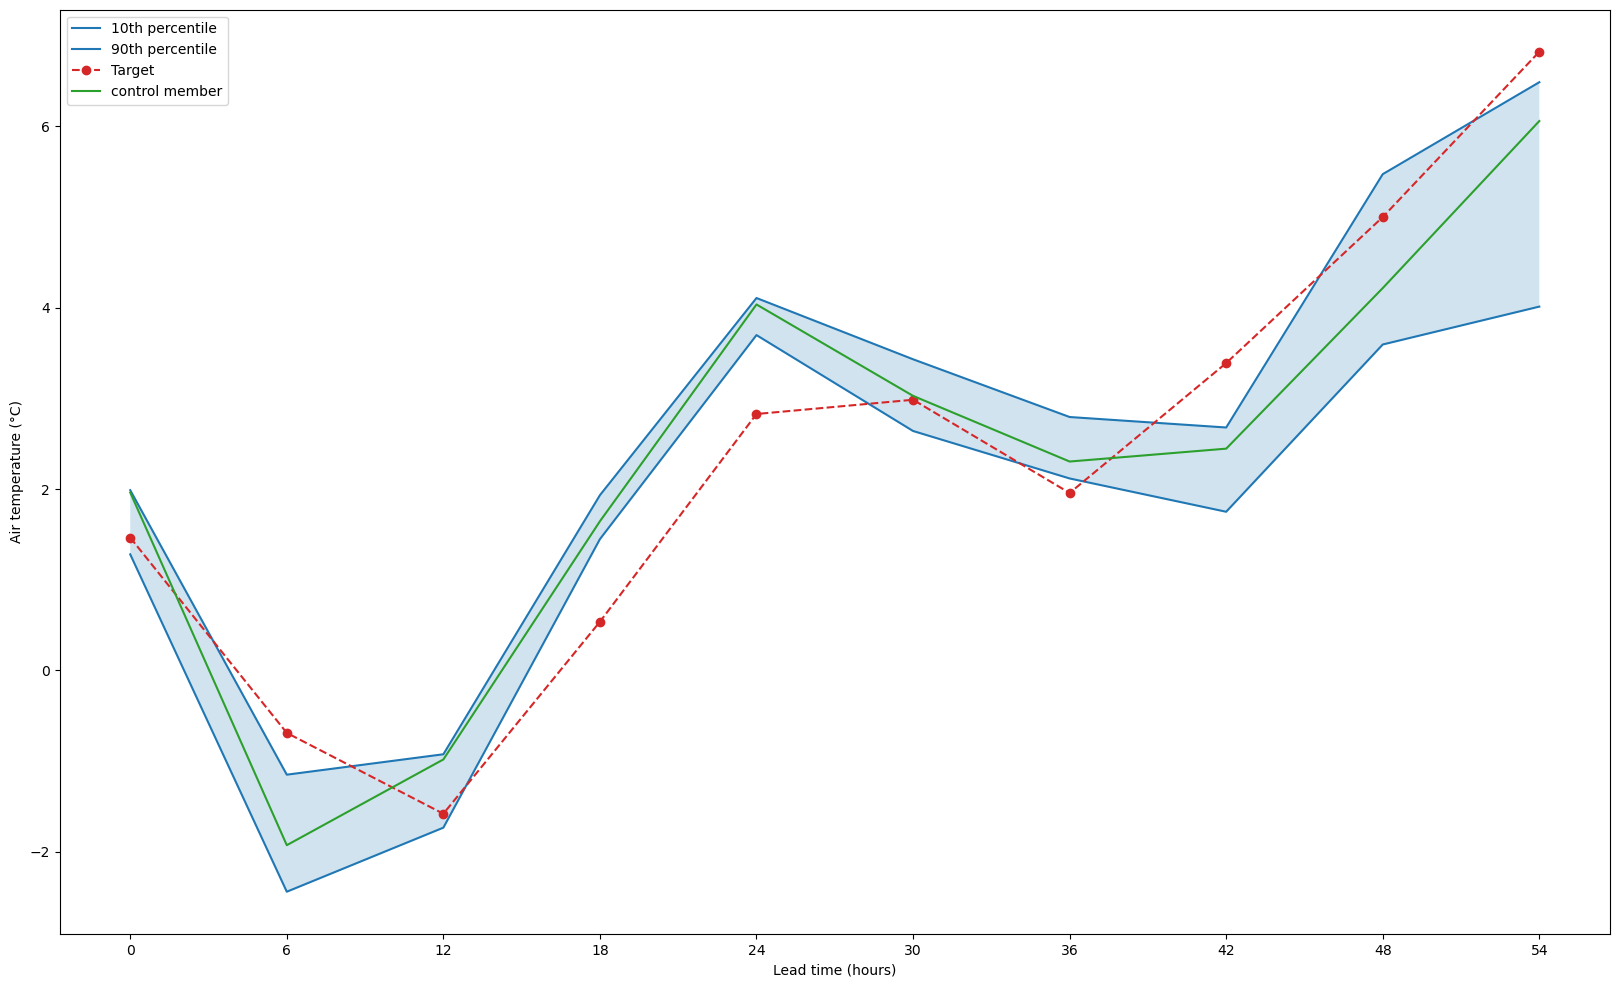

In [7]:
# Pick a specific gridpoint (must be between 0 and 127 for this particular dataset)
ix = 10
iy = 10
it = 10
lower = dataset["predictors"].values[it,:,ix,iy,np.where(dataset["predictor"] == "air_temperature_0.1_2m")[0][0]]
upper = dataset["predictors"].values[it,:,ix,iy,np.where(dataset["predictor"] == "air_temperature_0.9_2m")[0][0]]
middle = dataset["predictors"].values[it,:,ix,iy,np.where(dataset["predictor"] == "air_temperature_2m")[0][0]]
middle_label = "control member"
target = dataset["targets"].values[it,:,ix,iy]
leadtimes = dataset["leadtime"].values.astype(np.float32) // 1e9
print(leadtimes)
plot_timeseries(middle, target, lower, upper, leadtimes, middle_label)

_**Exercise**: Try plotting timeseries for a few other leadtimes and/or gridpoints. What can you subjectively say about the quality of the raw forecasts in the dataset?_

## Part 2: A simple fully connected model

### Loading the full dataset

We will use the climetlab loader again, but this time to load the full Tier 1 dataset. The loader has some additional options that can be specifed:

| Variable | Example value | Desciption |
|:---------|:--------------|:------------|
| predict_diff | True | Change the target to be the difference between the target and raw forecast |
| normalize | True |  Normalize the predictors |



The loader turns the data into a xarray dataset, which can be passed into the training model that we will build.

We split the dataset into a training, validation and testing dataset. In order to capture all weather types in the training dataset, we use a full year of forecasts and observations (03-2020 til 02-2021) for the training dataset. For the validation we use every second day for the second year (03-2021 til 03-2022) and for the testing the set of days one day later than the validation period.

In [8]:
""" Split the dataset into training, validation, and testing, based on dates """
datasets = dict()
loader = cml.load_dataset("maelstrom-yr", dates=pd.date_range(start="2020-03-01", end="2021-02-28", freq="1D"), size="5GB", location="/p/project/training2330/AP1/")
datasets["train"] = loader.to_xarray()
loader = cml.load_dataset("maelstrom-yr", dates=pd.date_range(start="2021-03-01", end="2022-02-28", freq="2D"), size="5GB", location="/p/project/training2330/AP1/")
datasets["val"] = loader.to_xarray()
loader = cml.load_dataset("maelstrom-yr", dates=pd.date_range(start="2021-03-02", end="2022-02-28", freq="2D"), size="5GB", location="/p/project/training2330/AP1/")
datasets["test"] = loader.to_xarray()

#loader = cml.load_dataset("maelstrom-yr", size="5GB")
#full_dataset = loader.to_xarray()
#datasets["train"] = full_dataset.sel(time=slice("2020-03-01", "2021-01-31"))
#datasets["val"] = full_dataset.sel(time=slice("2021-02-01", "2022-02-28", 2))
#datasets["test"] = full_dataset.sel(time=slice("2021-02-02", "2022-02-28", 2))
#datasets["val"] = full_dataset.sel(time=slice("2021-02-01", "2021-07-31"))
#datasets["test"] = full_dataset.sel(time=slice("2021-08-01", "2022-02-28"))

for name, dataset in datasets.items():
    print(f"{name} dataset")
    print(datasets[name])

train dataset
<xarray.Dataset>
Dimensions:     (time: 361, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2020-03-01T03:00:00 ... 2021-02-28T21:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 0.346 1.129 ... 0.1716
    targets     (time, leadtime, y, x, target) float32 0.3591 -0.18 ... -4.224
val dataset
<xarray.Dataset>
Dimensions:     (time: 182, x: 128, y: 128, leadtime: 10, pre

#### Loss function

As we are not just predicting one deterministic temperature, but also its uncertainty (10th and 90th percentile) we use a loss function that computes one loss (error) for our different quantiles. The loss function is defined below:

**ESTO SE PONE LUEGO EN LA CONSTRUCCION DE LA RED NEURONAL Y ES LO QUE DETERMINA QUE CUANTIL ES CADA NEURONA DE SALIDA, TIENE Q CUADRAR EN SHAPE CON num_outputs**

In [9]:
#prints
#(1, 10, 128, 128, 1) (1, 10, 128, 128, 3)
#Tensor("lambda/add_2:0", shape=(1, 10, 128, 128), dtype=float32)
#Tensor("lambda/sub_4:0", shape=(1, 10, 128, 128), dtype=float32)

""" The quantile score readable for keras/tensorflow"""
def quantile_score(y_true, y_pred, quantile_levels):
    #print(y_true.shape, y_pred.shape)
    qtloss = 0
    for i, quantile_level in enumerate(quantile_levels):
        err = y_true[..., 0] - y_pred[..., i] # cada i es cada quantile predicho por la red
        qtloss += (quantile_level - tf.cast((err < 0), tf.float32)) * err # es += porq la definicion de funcion de perdida esq error total es la suma para los quantiles
    #print(qtloss)
    #print(err)
    return K.mean(qtloss) / len(quantile_levels)

Let's plot the loss function:

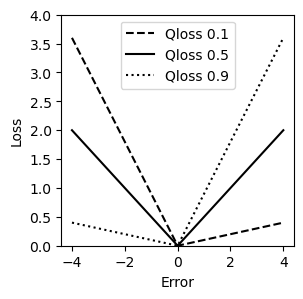

In [36]:
quantile_levels = [0.1, 0.5, 0.9]

""" The error is the true - prediction"""
err = np.arange(-4, 5)

mae = abs(err)
line_types = ["k--", "k-", "k:"]
for i, quantile_level in enumerate(quantile_levels):
    qtloss = (quantile_level- (err < 0)) * err
    plt.plot(err, qtloss, line_types[i], label="Qloss %s" %quantile_level)
    plt.ylim([0, 4])
#plt.plot(err, mae)
plt.xlabel("Error")
plt.ylabel("Loss")
plt.legend()
plt.gcf().set_size_inches([3, 3])
plt.show()


- _**Exercise**: Why are the 10th and 90th percetiles penalized diferently for negative/postive errors,while the median is not?_

- _**Exercise**: What is the relationship between Qloss 0.5 and the mean absolute error? (try to plot MAE on the same graph)_
    - mae is half the q0.5 loss, do the math in the qloss function in the slides, for q0.5 it is 1-.5 * (y-q)

#### Setting up the model

We will start by setting up a simple fully connected model.


There are several ways to build a Neural network in Keras/Tensorflow. The simplest is the sequential approach. Here we write a function which outputs a model, ready to be trained.

In [11]:
def build_fully_connected_sequantial_model( input_shape: int, 
                            number_of_units: int, 
                            number_of_layers: int, 
                            activation: str, 
                            learning_rate = 10**(-3),
                            number_of_outputs: int = 3, 
                            final_activation: str = 'linear'
        ):

    """ First we clear any previously build model from memory, so the keras does not keep adding layers to an old network"""
    keras.backend.clear_session()

    """ Create a model object """
    model = keras.Sequential()

    """ Define inputlayer with number of units equal to the number of predictors"""
    model.add(keras.layers.Input(input_shape,name="Inputs"))

    """ Then we stack on the number of consectutive dense hidden layers with their activation function"""
    for i in range(number_of_layers-1):
        model.add(keras.layers.Dense(number_of_units, activation=activation))

    """ Define the output layer with number of units actual to the number of quantiles we want to predict and a linear activation function"""
    model.add(keras.layers.Dense(num_outputs, activation=final_activation))

    """Next we need to specify the optimiser we want to use and what learning rate to use """
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    """ Define the loss function. Keras has build in loss function like mean absolute error, then you just pass in the string mae. Because we use a tailored loss function for our application we have to pass in our own defined method.
        We have to define it in the form of a lamba method, because keras only accepts method with two inputs (precitedion and truth), we want to also pass the quantile levels into the method however."""
    loss = lambda x, y: quantile_score(x, y, quantile_levels) # this gives the order of the output neurons, puede resultar en 10 percentil ser mayor q el 90, eso es lo de 'physics constraint'

    """ Finally we compile the model, specifying the optimizer and loss we want to minimise """
    model.compile(optimizer=opt, loss=loss)

    """ Afterwards we can summeray the model, which prints out the shape of the network"""
    model.summary()
    return model

For more advanced architectures, it's good to use the functional approach to writing networks. This is very similar to the syntax of Pytorch.
Here we stitch together a model, by passing one layer into the next.

In [12]:
def build_fullyconnected_functional(input_shape: int, 
                              number_of_units: int, 
                              number_of_layers: int, 
                              activation: str,
                              learning_rate = 10**(-3),
                              number_of_outputs: int = 3,
                              final_activation: str = 'linear'
):

    """ First we clear any previously build model from memory, so the keras does not keep adding layers to an old network"""
    keras.backend.clear_session()
    
    """First we create an input layer"""
    inputs = keras.layers.Input(input_shape,name="Inputs")
    """ Pass it to a name we will reuse"""
    hidden = inputs
    for i in range(number_of_layers-1):
        """Now we repeatedly apply a Dense layer to the object
        each time this adds another layer onto the stack"""
        hidden = keras.layers.Dense(number_of_units,activation=activation)(hidden)

    """ Finally stitch on the output layer"""
    output = keras.layers.Dense(num_outputs,activation='linear')(hidden)

    """And the model itself is created by specifying the input layers and output layers.
        With this approach we can create a model with multiple
        inputs and outputs, if appropriate for the problem. """
    model= tf.keras.models.Model(inputs=inputs,outputs=output)

    opt = tf.keras.optimizers.Adam(learning_rate)
    loss = lambda x, y: quantile_score(x, y, quantile_levels)

    model.compile(loss=loss, optimizer=opt)
    model.summary()
    return model

Let's build a model using one of the methods above:

In [13]:
datasets["train"]["predictors"].shape

(361, 10, 128, 128, 14)

In [14]:
datasets["train"]

<xarray.Dataset>
Dimensions:     (time: 361, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2020-03-01T03:00:00 ... 2021-02-28T21:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 0.346 1.129 ... 0.1716
    targets     (time, leadtime, y, x, target) float32 0.3591 -0.18 ... -4.224

In [15]:
input_shape = datasets["train"]["predictors"].shape[1:] # the first dimension is the number of samples in tensorflow
quantile_levels = [0.1, 0.5, 0.9]
num_outputs = len(quantile_levels)

number_of_units = 6
number_of_layers = 4

simple_model = build_fully_connected_sequantial_model(input_shape, number_of_units, number_of_layers, "relu", 10e-3, num_outputs, "linear")
#simple_model = build_fullyconnected_functional(input_shape, number_of_units, number_of_layers, "relu", 10e-3, num_outputs, "linear")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 128, 128, 6)   90        
                                                                 
 dense_1 (Dense)             (None, 10, 128, 128, 6)   42        
                                                                 
 dense_2 (Dense)             (None, 10, 128, 128, 6)   42        
                                                                 
 dense_3 (Dense)             (None, 10, 128, 128, 3)   21        
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
_________________________________________________________________


- _**Exercise**: Unravel the total number of trainable parameters. How is this linked to the number of layers and units?_ 
    - Sum the "Param #" columns

In [16]:
print(f"First layer: {number_of_units * (input_shape[-1]+1)}")
print(f"Second layer: {(number_of_units+1)*number_of_units}") # bias not connected to previous layer
print(f"Thirds layer: {(number_of_units+1)*number_of_units}")
print(f"Second layer: {(number_of_units+1)*3}") # 3 is the output layer

First layer: 90
Second layer: 42
Thirds layer: 42
Second layer: 21


#### Train the model

In [17]:
list(datasets)

['train', 'val', 'test']

In [18]:
datasets["val"]

<xarray.Dataset>
Dimensions:     (time: 182, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-03-01T03:00:00 ... 2022-02-28T21:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 1.323 2.277 ... 0.1716
    targets     (time, leadtime, y, x, target) float32 -0.4216 0.8873 ... -4.589

In [19]:
history = simple_model.fit(datasets["train"]["predictors"].values, 
                    datasets["train"]["targets"].values, 
                    batch_size=1,
                    epochs=2, 
                    validation_data=(datasets["val"]["predictors"].values, datasets["val"]["targets"].values))
print(history.history)

Epoch 1/2
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
361/361 [==============================] - 6s 9ms/step - loss: 1.5099 - val_loss: 0.4784
Epoch 2/2
361/361 [==============================] - 2s 6ms/step - loss: 0.4587 - val_loss: 0.4171
{'loss': [1.5099083185195923, 0.4587125778198242], 'val_loss': [0.47840994596481323, 0.41710570454597473]}


#### Visualize the training performance

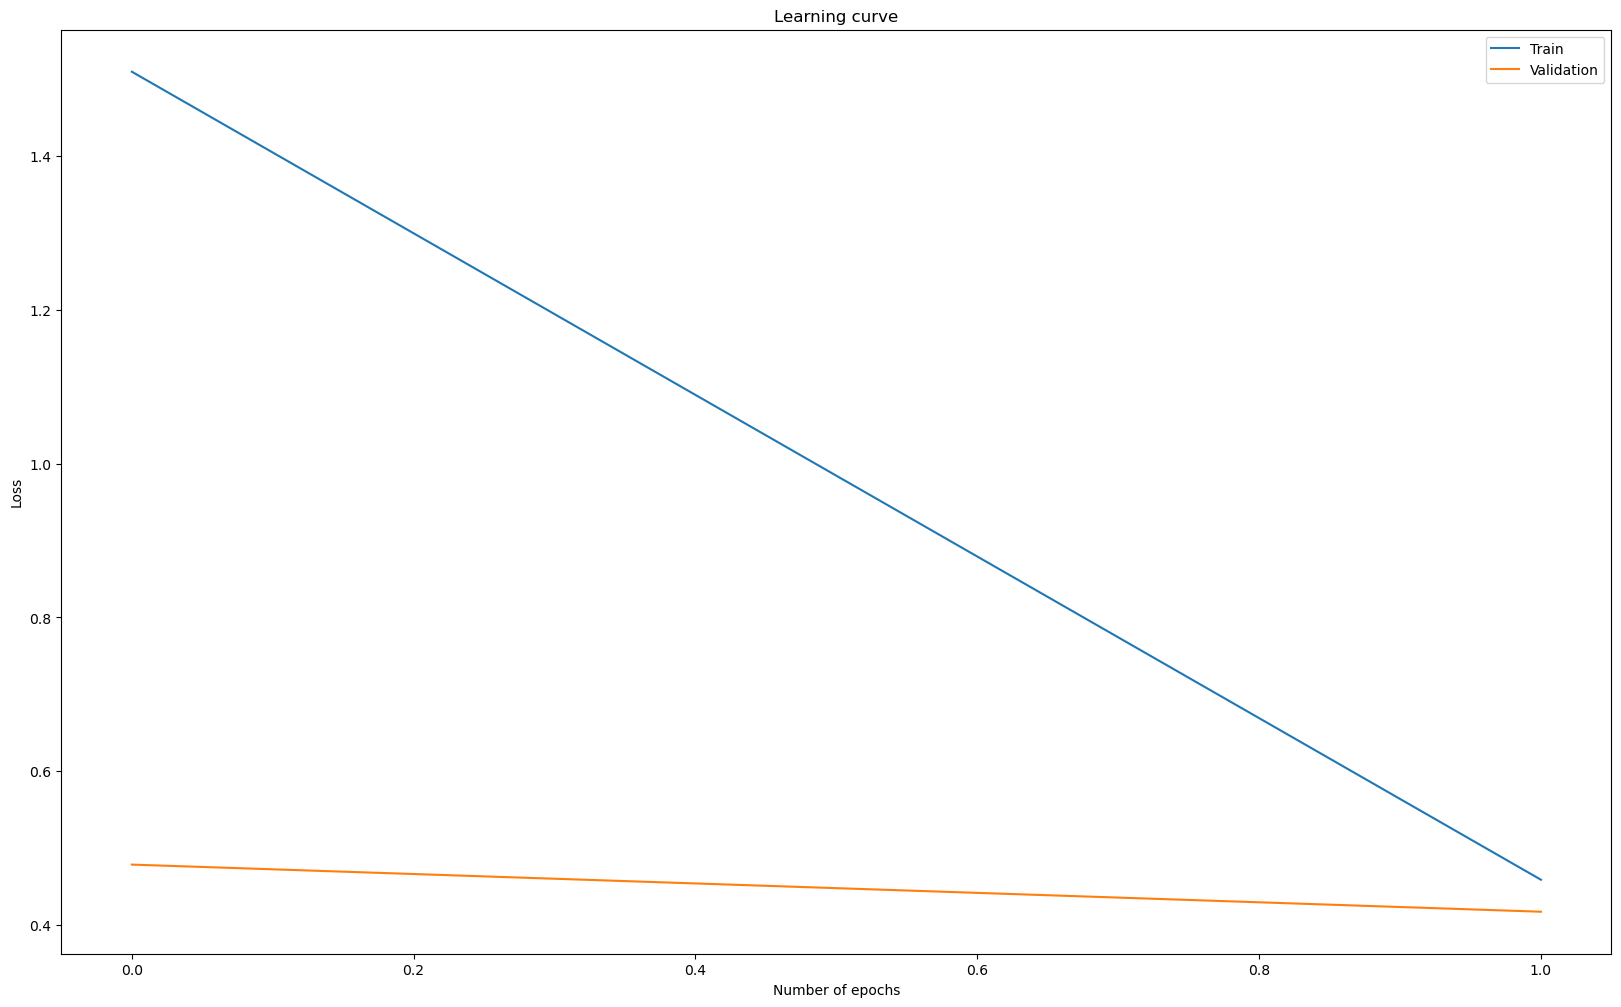

In [20]:
plt.plot(history.epoch, history.history["loss"], label="Train")
plt.plot(history.epoch, history.history["val_loss"], label="Validation")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Learning curve")
plt.legend()
plt.show()

The graph above gives us much information about how well our model is learning, if it is overfitting or underfitting and how fast it learns
- _**Exercise**_: What does the graph above tell you about the bias and variance of our trained model?
- _**Exercise**_: Try modifying various hyper-parameters of the model. For example the learning rate, number of layers and units, or the activation function (https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6).

#### Testing the model on the testing dataset

In [21]:
print("Test dataset:")
print(datasets["test"])
# predictions = simple_model.predict(datasets["test"]["predictors"].values)
predictions = simple_model.predict_on_batch(datasets["test"]["predictors"].values)

Test dataset:
<xarray.Dataset>
Dimensions:     (time: 181, x: 128, y: 128, leadtime: 10, predictor: 14,
                 target: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-03-02T09:00:00 ... 2022-02-27T15:0...
  * x           (x) float32 -3.104e+05 -3.094e+05 ... -1.844e+05 -1.834e+05
  * y           (y) float32 -4.173e+05 -4.163e+05 ... -2.913e+05 -2.903e+05
  * leadtime    (leadtime) timedelta64[ns] 0 days 00:00:00 ... 2 days 06:00:00
    latitude    (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    longitude   (y, x) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
  * predictor   (predictor) object 'air_temperature_0.1_2m' ... 'model_laf'
  * target      (target) object 'mean'
Data variables:
    predictors  (time, leadtime, y, x, predictor) float32 3.738 4.94 ... 0.1716
    targets     (time, leadtime, y, x, target) float32 3.482 3.788 ... 1.346


Let's plot the predictions for for an example case:

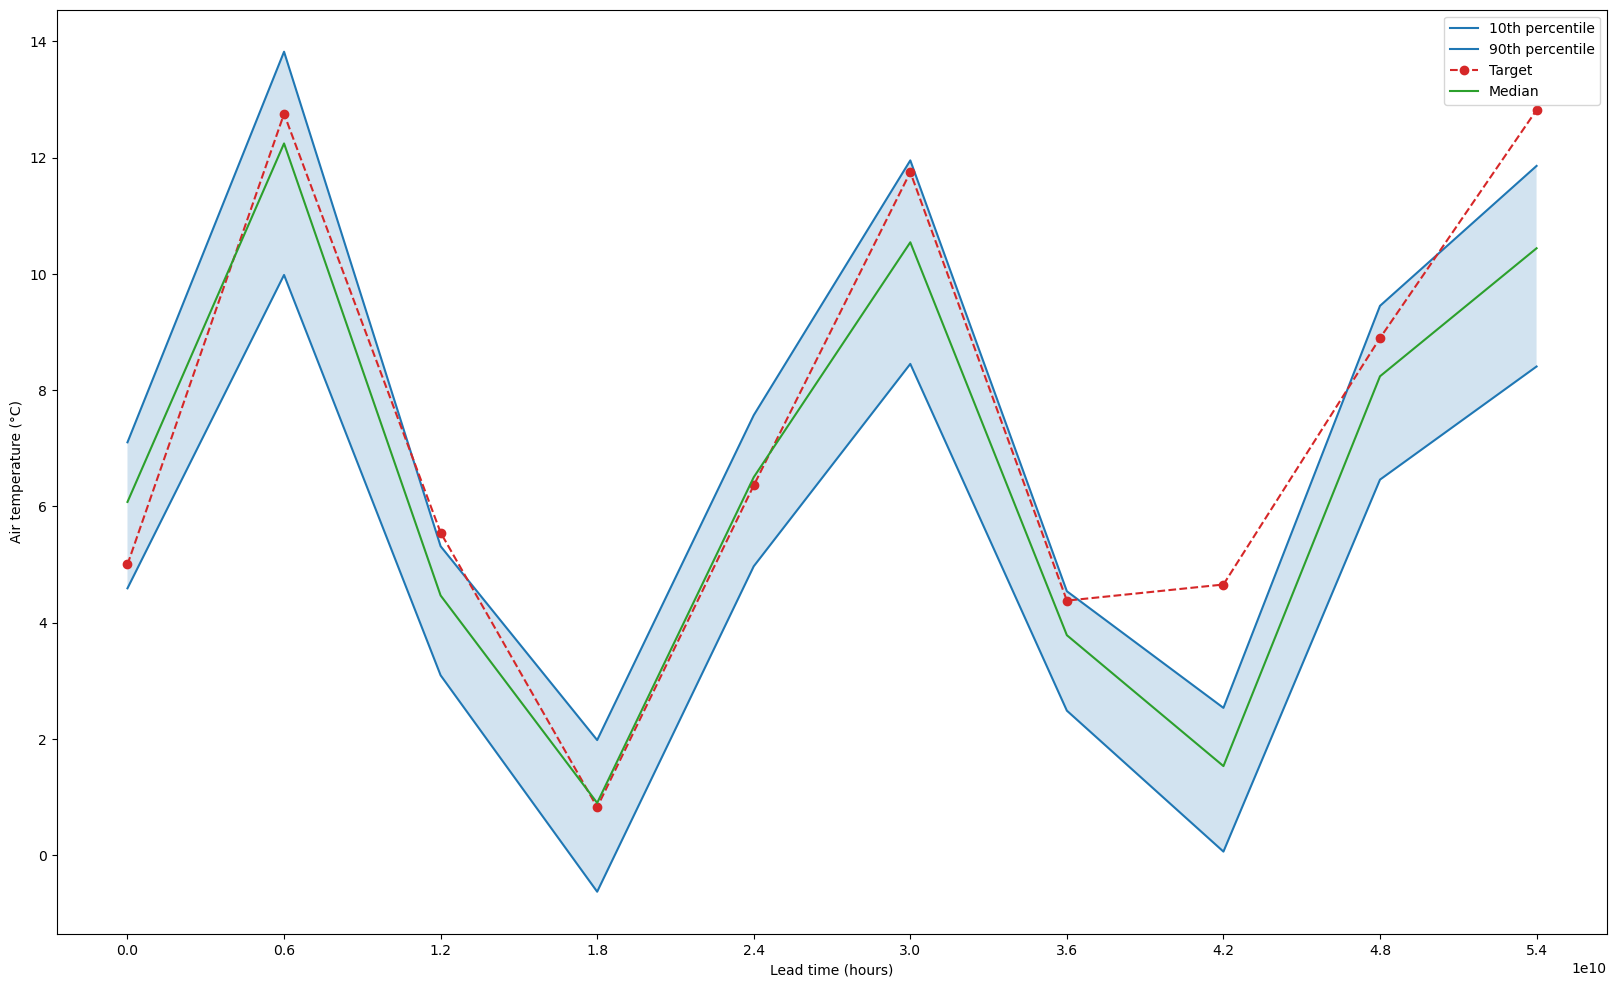

In [22]:
x = 5
y = 5
tindex = 10
percentile10 = predictions[tindex,:,y,x,0]
median = predictions[tindex,:,y,x,1]
percentile90 = predictions[tindex,:,y,x,2]
target = datasets["test"]["targets"].values[tindex,:,y,x,0]
leadtimes = datasets["test"]["leadtime"].values.astype(float)
plot_timeseries(median, target, percentile10, percentile90, leadtimes, middle_label="Median")

Did the forecast improve? What got better and what got worse? What can we change in our model to improve the prediction?

## Part 3: Convolutional neural network (CNN)

In the simple neural network we build above there is no information passed between the different gridpoints or leadtime dimension. The parameters in the network are updated across all gridpoints and leadtimes. However you can imagine that the temperature in one gridpoint can have information for the neighbouring gridpoint or similarly for the previous or next leadtime. We can make use of the information of neighbouring gridpoints/leadtimes by using convolutional layers in our neural network. 

Below we build a convolutional neural network in the same way as we build the simple network, but this time with convolutional layers instead of dense layers:

In [23]:
def build_conv_model(input_shape: int, 
                        filter_size: list,
                        number_of_filters_per_layer: list, 
                        stride: int,
                        activation: str, 
                        padding: str = "same",
                        learning_rate = 10**(-3),
                        number_of_outputs: int = 3, 
                        final_activation: str = 'linear'):

    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape))

    """ Then we stack on the number of consectutive convolutional layers with their filters, activation function"""
    for num_filter in number_of_filters_per_layer:
        model.add(keras.layers.Conv3D(num_filter, filter_size, stride, padding, activation=activation))

    model.add(keras.layers.Dense(num_outputs, activation=final_activation))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = lambda x, y: quantile_score(x, y, quantile_levels)
    model.compile(optimizer=opt, loss=loss)
    model.summary()
    return model

Let's build a convolutional neural network with 3 convolutional layers. The first layers applies 15 different filters and the last 2 layers apply 5 different filters. Let's start by only applying the filters in the spatial dimension (filtersize_time_dim=1).

In [24]:
""" The number of convolution layers is defined by the length of the num_filters_per_layer parameter. 
    So in the example below we will have 3 convolutional layers"""
num_filters_per_layer=[12,5,5] # 3 layers
filtersize_time_dim=1
filtersize_spatial_dim=3

filtersize=[filtersize_time_dim, filtersize_spatial_dim, filtersize_spatial_dim]
stride=1
activation="relu"
padding="same"

conv_model = build_conv_model(input_shape, filtersize, num_filters_per_layer, stride, activation, padding)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 128, 128, 12)  1524      
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 128, 128, 5)   545       
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 128, 128, 5)   230       
                                                                 
 dense (Dense)               (None, 10, 128, 128, 3)   18        
                                                                 
Total params: 2,317
Trainable params: 2,317
Non-trainable params: 0
_________________________________________________________________


- _**Exercise**: We have 2317 (!) trainable parameters. Explain the number of trainable parameters._

In [25]:
input_shape, num_filters_per_layer, filtersize_time_dim, filtersize_spatial_dim

((10, 128, 128, 14), [12, 5, 5], 1, 3)

In [56]:
# tambn incluir el bias
print(f"{filtersize_spatial_dim**2*filtersize_time_dim*num_filters_per_layer[0]*input_shape[-1] + num_filters_per_layer[0]}")
print(f"{filtersize_spatial_dim**2*filtersize_time_dim*num_filters_per_layer[1]*12 + num_filters_per_layer[1]}") # el 12 es la salida de la capa anterior
print(f"{filtersize_spatial_dim**2*filtersize_time_dim*num_filters_per_layer[2]*5 + num_filters_per_layer[2]}") # el 5 es la salida de la capa anterior
print(f"{5*3+3}") # 5 de la salida anterior, 3 de esta capa + 3 de bias

1524
545
230
18


## Part 4: Comparing different models

In machine learning we often want to compare the relative performance of different models, to see which model gives the best results.
- _**Exercise**: Use the cell below to train the different models we have build so far (simple dense network and the convolutional) and add more models to the list if you want to compare their relative performance._
- _**Exercise**: Change the hyperparameters of the convolutional neural network, e.g. expand the filter to also convolve the time dimension. Does this increase the performance?_

In [27]:
model_name = ["simple", "CCN"]
models = [simple_model, conv_model]

results = []
test_losses = list()
for i, model in enumerate(models):
    model.fit(datasets["train"]["predictors"].values, 
                datasets["train"]["targets"].values, 
                batch_size=1,
                epochs=5, 
                validation_data=(datasets["val"]["predictors"].values, datasets["val"]["targets"].values))
    #results += [model.predict(datasets["test"]["predictors"].values)]
    results += [model.predict_on_batch(datasets["test"]["predictors"].values)]
    test_losses += [quantile_score(datasets["test"]["targets"].values, results[i], quantile_levels).numpy()]

for i in range(len(models)):    
    print("Test loss of "+model_name[i]+":"+str(test_losses[i]))

Epoch 1/5
361/361 [==============================] - 3s 9ms/step - loss: 0.4309 - val_loss: 0.4346
Epoch 2/5
361/361 [==============================] - 2s 6ms/step - loss: 0.4140 - val_loss: 0.4150
Epoch 3/5
361/361 [==============================] - 2s 6ms/step - loss: 0.4191 - val_loss: 0.3754
Epoch 4/5
361/361 [==============================] - 2s 6ms/step - loss: 0.4328 - val_loss: 0.5200
Epoch 5/5
361/361 [==============================] - 2s 6ms/step - loss: 0.4085 - val_loss: 0.3844
Epoch 1/5
361/361 [==============================] - 6s 11ms/step - loss: 1.3527 - val_loss: 0.7063
Epoch 2/5
361/361 [==============================] - 2s 7ms/step - loss: 0.6534 - val_loss: 0.5104
Epoch 3/5
361/361 [==============================] - 2s 6ms/step - loss: 0.5189 - val_loss: 0.4660
Epoch 4/5
361/361 [==============================] - 2s 7ms/step - loss: 0.4663 - val_loss: 0.6572
Epoch 5/5
361/361 [==============================] - 2s 6ms/step - loss: 0.4489 - val_loss: 0.6063
Test loss